In [33]:
import numpy as np
import numpy.random as r#.normal
import pandas as pd
import matplotlib.pyplot as plt
import random

from importlib import reload

import kalman
reload(kalman)

<module 'kalman' from 'c:\\Users\\Alex\\Desktop\\SEB\\Tests\\kalman.py'>

In [34]:
DISTURBANCE_MAGNITUDE = 0.1
TERMINAL_VELOCITY = -20
g = -9.8
DELTA_T = 20e-3 #interval in seconds

rnjesus = r.default_rng()

In [35]:
x = np.matrix([[0.],  #pos
              [1.],  # velocity
              [2.]]) # accel

F = np.matrix([[1,DELTA_T, DELTA_T**2 / 2],  #state transition matrix
              [0,1, DELTA_T],
              [0, 0, 1]])

sigma_b = 0.5 # barometer
sigma_a = 0.5 # accelerometer

R = np.matrix([[sigma_b**2, 0],
              [0, sigma_a**2]])

In [36]:
# def update(x_0, v, a, delta_t):
#     val = x_0 + v*delta_t+(a*delta_t**2)/2
#     #print("{}, {}, {}".format(val, disturbance_factor, val*disturbance_factor))
#     velocity = (val - x_0) / delta_t
#     with_error = val
#     if(val > 1000):
#         disturbance = random.uniform(-1,1)*DISTURBANCE_MAGNITUDE*val
#         with_error += disturbance
#     return val, velocity, with_error


a_max = 50
t_ramp_up = 0.1
t_hold = 8
t_ramp_down = 0.6

def acceleration(time):
    
    if(time < t_ramp_up):
        return time * (a_max + g) / t_ramp_up
    elif(time < (t_ramp_up + t_hold)):
        return a_max + g
    elif (time < (t_ramp_up + t_hold + t_ramp_down)):
        return a_max - (time- (t_ramp_up + t_hold)) * a_max / t_ramp_down + g
    else :
        return 0 + g

def generate_data(noisy = False):
    state = []
    x = np.matrix([[10], [5], [0]])
    t = 0
    while (x[0,0] > 0):
        pos_disturbance = 0 if not noisy or t < t_ramp_up else rnjesus.normal(0, sigma_b, 1)
        x[0,0] += pos_disturbance
        velocity_disturbance = 0 if not noisy else rnjesus.normal(0, sigma_b, 1)
        x[1,0] += velocity_disturbance
        x = F@x #np.matmul(F,x)
        t += DELTA_T
        accel_disturbance = 0 if not noisy else rnjesus.normal(0, sigma_a, 1)
        #print(disturbance)
        x[2,0] = acceleration(t) + accel_disturbance
        state.append(x)
    return np.asarray(state), np.linspace(0, t, len(state))
    

In [37]:
raw_data, T = generate_data(True)
print("total time: {} s".format(T[-1]))
print("num steps: {}".format(len(raw_data)))

total time: 74.5800000000023 s
num steps: 3729


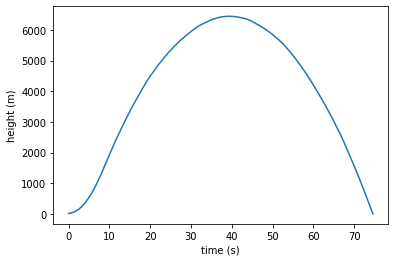

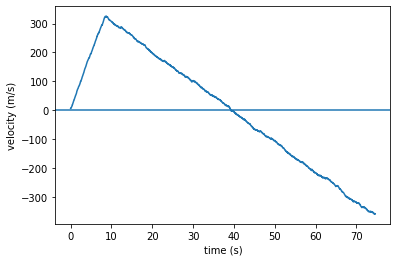

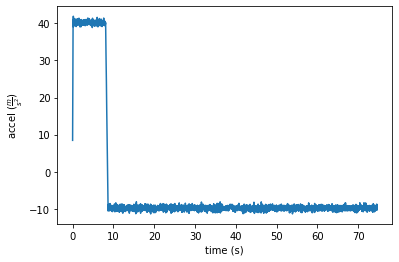

In [38]:
kalman.plot_states(T, raw_data, 0, 100000)

$$x_k = F x_{k-1} + B a_k$$

In [39]:
""" converge K
for i in range(50):
    S = (H@P)@H.T + R
    K = (P@H.T)@np.linalg.inv(S)
    P = (np.identity(3) - K@H)@P
    P = A@(P@A.T) + Q
"""
    
H = np.matrix([[1, 0, 0],
               [0, 0, 1]])

#print(K)
print(H)
#print(P)

[[1 0 0]
 [0 0 1]]


In [40]:
#create vector of measurements
z = np.asarray([H@x for x in raw_data])
print(np.shape(z))

(3729, 2, 1)


In [41]:
filtered_data = kalman.kalman(z)

# Various K matrices at end of filtering for different runs.
Exactly match

[[1.41321392e-03 1.21113413e-07]
 [9.99293022e-04 1.71572729e-04]
 [1.21113413e-07 8.28427125e-01]]
 
 [[1.41321392e-03 1.21113413e-07]
  [9.99293022e-04 1.71572729e-04]
  [1.21113413e-07 8.28427125e-01]]
  
 [[1.41321392e-03 1.21113413e-07]
  [9.99293022e-04 1.71572729e-04]
  [1.21113413e-07 8.28427125e-01]]

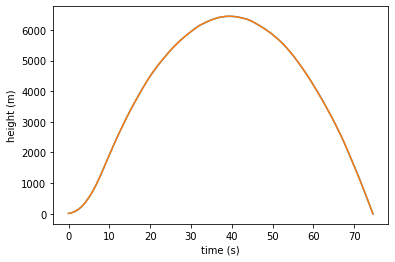

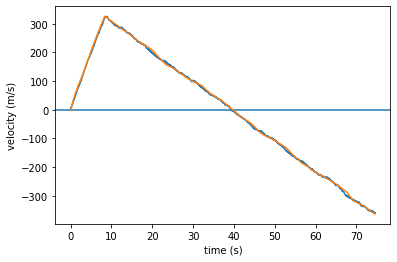

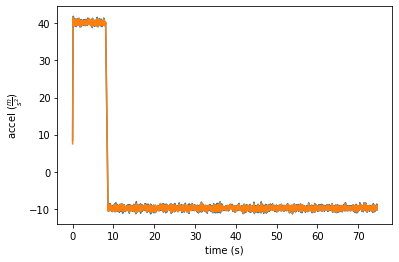

In [42]:
kalman.plot_states(T, raw_data, 0, 100000, filtered_data)

2025


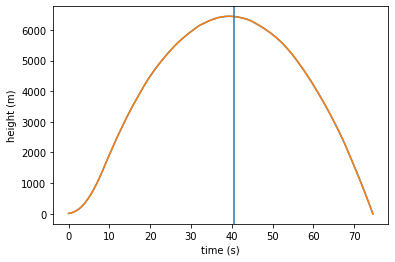

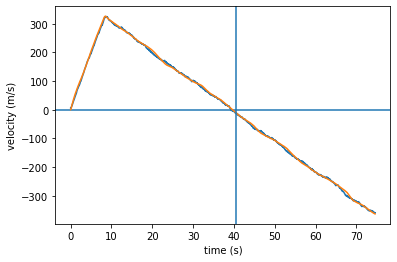

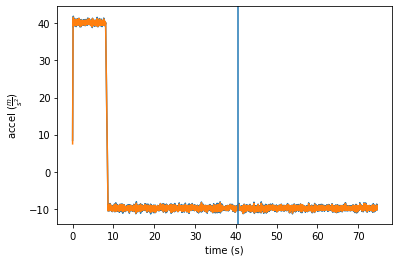

In [44]:
apogee = kalman.Apogee(filtered_data[:,0,0])
print(apogee)
kalman.plot_states(T, raw_data, 0, 100000, filtered_data, T[apogee])